In [45]:
%pip install numpy
%pip install pandas
%pip install scikit-learn
%pip install xgboost
%pip install shap

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [55]:
import os

import numpy as np
import pandas as pd

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    average_precision_score,
)
from sklearn.model_selection import train_test_split

import shap
import xgboost as xgb

shap.initjs()

# Read dataset

In [56]:
csv_path = "fastf1_lap_dataset.csv"

if not os.path.exists(csv_path):
    raise FileNotFoundError(f"CSV not found at {csv_path}")

df = pd.read_csv(csv_path)
df = df.drop("grid_position", axis=1)

# Remove ever row where is_pit is True
df = df[df['is_pit'] == False]

df['current_position'] = df['current_position'].fillna(method='ffill')
df['lap_time_s'] = df['lap_time_s'].fillna(method='ffill').fillna(method='bfill')
df['tyre_compound'] = df['tyre_compound'].fillna(method='ffill')
df['laps_on_current_tyre'] = df['laps_on_current_tyre'].fillna(df['laps_on_current_tyre'].median())

print(df.isna().sum())
df[df.isna().any(axis=1)]

driver_id               0
team_id                 0
circuit_id              0
total_race_laps         0
year                    0
session_name            0
current_position        0
gap_to_leader_s         0
gap_to_ahead_s          0
lap_time_s              0
laps_on_current_tyre    0
tyre_compound           0
safety_car_this_lap     0
lap_number              0
drs_enabled             0
track_temperature       0
air_temperature         0
has_rain                0
is_pit                  0
session_key             0
race_name               0
team_name               0
virtual_sc_this_lap     0
humidity                0
pressure                0
rainfall                0
wind_speed              0
wind_direction          0
dtype: int64


/var/folders/3t/lccpd1j15071g5nr0s6sjcr80000gn/T/ipykernel_68407/363405642.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['current_position'] = df['current_position'].fillna(method='ffill')
/var/folders/3t/lccpd1j15071g5nr0s6sjcr80000gn/T/ipykernel_68407/363405642.py:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['lap_time_s'] = df['lap_time_s'].fillna(method='ffill').fillna(method='bfill')
/var/folders/3t/lccpd1j15071g5nr0s6sjcr80000gn/T/ipykernel_68407/363405642.py:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['tyre_compound'] = df['tyre_compound'].fillna(method='ffill')


,driver_id,team_id,circuit_id,total_race_laps,year,session_name,current_position,gap_to_leader_s,gap_to_ahead_s,lap_time_s,...,is_pit,session_key,race_name,team_name,virtual_sc_this_lap,humidity,pressure,rainfall,wind_speed,wind_direction


# Format Dataset

In [57]:
import numpy as np

PACK_THRESHOLD = 2.0  # seconds

race_df = df[
    (~df["safety_car_this_lap"]) &
    (~df["virtual_sc_this_lap"]) &
    df["lap_time_s"].notna()
].copy()

circuit_baseline = (
    race_df
    .groupby("circuit_id")["lap_time_s"]
    .median()
    .reset_index()
    .rename(columns={"lap_time_s": "circuit_median_lap"})
)

df = df.merge(circuit_baseline, on="circuit_id", how="left")

df["lap_delta_s"] = df["lap_time_s"] - df["circuit_median_lap"]

# ------------------------------------------------------------------
# Driver skill metric
# ------------------------------------------------------------------

session_col = "session_key"
clean_laps_for_skill = df[
    (~df["safety_car_this_lap"]) &
    (~df["virtual_sc_this_lap"]) &
    df["lap_time_s"].notna()
].copy()

session_stats = (
    clean_laps_for_skill
    .groupby(session_col)["lap_time_s"]
    .agg(session_median_lap="median", session_std_lap="std")
    .reset_index()
)

clean_laps_for_skill = clean_laps_for_skill.merge(
    session_stats,
    on=session_col,
    how="left",
)

clean_laps_for_skill["session_std_lap"] = clean_laps_for_skill["session_std_lap"].replace(0, np.nan)

clean_laps_for_skill["session_perf_z"] = -(
    clean_laps_for_skill["lap_time_s"] - clean_laps_for_skill["session_median_lap"]
) / clean_laps_for_skill["session_std_lap"]

clean_laps_for_skill["session_perf_z"] = clean_laps_for_skill["session_perf_z"].fillna(0.0)

driver_session_skill = (
    clean_laps_for_skill
    .groupby(["driver_id", session_col])["session_perf_z"]
    .mean()
    .reset_index()
)

driver_skill_raw = (
    driver_session_skill
    .groupby("driver_id")["session_perf_z"]
    .mean()
)

driver_skill = (driver_skill_raw - driver_skill_raw.mean()) / driver_skill_raw.std()

df = df.merge(
    driver_skill.rename("driver_skill"),
    on="driver_id",
    how="left",
)

df["driver_skill"] = df["driver_skill"].fillna(0.0)

# ------------------------------------------------------------------
# Traffic feature: pack_density
# ------------------------------------------------------------------

pack_density = pd.Series(np.nan, index=df.index)
for (sess, lap), grp in df.groupby(["session_key", "lap_number"], sort=False):
    grp_sorted = grp.sort_values("current_position")
    ahead_gap = grp_sorted["gap_to_ahead_s"].to_numpy()
    behind_gap = np.full_like(ahead_gap, np.nan, dtype=float)
    for i in range(len(grp_sorted) - 1):
        behind_gap[i] = ahead_gap[i + 1]
    pdensity = ((ahead_gap <= PACK_THRESHOLD).astype(int) + (np.nan_to_num(behind_gap) <= PACK_THRESHOLD).astype(int))
    pack_density.loc[grp_sorted.index] = pdensity

df["pack_density"] = pack_density.fillna(0).astype(int)

# ------------------------------------------------------------------
# Weather features
# ------------------------------------------------------------------
weather_cols = [
    "track_temperature",
    "air_temperature",
    "humidity",
    "pressure",
    "rainfall",
    "wind_speed",
    "wind_direction",
]
for col in weather_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")
        df[col] = df[col].fillna(df[col].median())

# ------------------------------------------------------------------
# Final features
# ------------------------------------------------------------------

df["race_progress"] = df["lap_number"] / df["total_race_laps"]
df["laps_remaining"] = df["total_race_laps"] - df["lap_number"]

filtered_df = df[[
    "circuit_id",
    "laps_on_current_tyre",
    "tyre_compound",
    "race_progress",
    "rainfall",
    "gap_to_ahead_s",
    "pack_density",
    "track_temperature",
    "air_temperature",
    "humidity",
    "pressure",
    "wind_speed",
    "wind_direction",
    "year",
    "driver_skill",
    "lap_delta_s",
]].copy()

filtered_df["circuit_id"] = filtered_df["circuit_id"].astype("category")
filtered_df["tyre_compound"] = filtered_df["tyre_compound"].astype("category")

circuit_cat = filtered_df["circuit_id"].dtype
compound_cat = filtered_df["tyre_compound"].dtype

circuit_median_map = circuit_baseline.set_index("circuit_id")["circuit_median_lap"].to_dict()
driver_skill_map = driver_skill.to_dict()


In [34]:
driver_skill_map

{'AIT': 0.07382246613394057,
 'ALB': 0.16389569928037115,
 'ALO': 0.1957102266324713,
 'ANT': 0.6530232609427813,
 'BEA': 0.10330284883760386,
 'BOR': -0.24160655484037788,
 'BOT': 0.5279169466568518,
 'COL': -0.43786620960427686,
 'DEV': -0.19732569958024251,
 'DOO': -4.8582650704519175,
 'ERI': -0.20089707051791594,
 'FIT': -0.11016230017201759,
 'GAS': 0.17983434307073534,
 'GIO': -0.21978182760128728,
 'GRO': -0.18952707173318808,
 'HAD': 0.14165348975457975,
 'HAM': 1.3963939479732745,
 'HAR': -0.728161644346584,
 'HUL': 0.055249090344850406,
 'KUB': -1.462059824647062,
 'KVY': 0.13371559831526014,
 'LAT': -0.42318606168041567,
 'LAW': -0.21171664638876309,
 'LEC': 1.0866422470120505,
 'MAG': -0.16358237933588096,
 'MAZ': -1.3084619660858368,
 'MSC': -0.4078152790077036,
 'NOR': 1.061308227152902,
 'OCO': -0.17835863631860366,
 'PER': 0.9253318315312046,
 'PIA': 1.2583612174379308,
 'RAI': 0.28706862973090147,
 'RIC': 0.4612099985691684,
 'RUS': 0.6332478117391315,
 'SAI': 0.76287

In [35]:
circuit_cat

CategoricalDtype(categories=['austin', 'baku', 'barcelona', 'budapest', 'hockenheim',
                  'imola', 'istanbul', 'jeddah', 'las_vegas', 'le_castellet',
                  'lusail', 'marina_bay', 'melbourne', 'mexico_city', 'miami',
                  'miami_gardens', 'monaco', 'monte_carlo', 'montréal',
                  'monza', 'mugello', 'nürburgring', 'portimão', 'sakhir',
                  'shanghai', 'silverstone', 'singapore', 'sochi',
                  'spa_francorchamps', 'spielberg', 'suzuka', 'são_paulo',
                  'yas_island', 'yas_marina', 'zandvoort'],
, ordered=False, categories_dtype=object)

In [36]:
driver_cat

NameError: name 'driver_cat' is not defined

In [37]:
compound_cat

CategoricalDtype(categories=['HARD', 'HYPERSOFT', 'INTERMEDIATE', 'MEDIUM', 'SOFT',
                  'SUPERSOFT', 'ULTRASOFT', 'UNKNOWN', 'WET'],
, ordered=False, categories_dtype=object)

In [58]:
X = filtered_df.drop("lap_delta_s", axis=1)
y = filtered_df["lap_delta_s"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Search for the best params

In [59]:
import numpy as np
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV, PredefinedSplit
from sklearn.metrics import mean_squared_error
import xgboost as xgb

# Your param grid
param_dist = {
    "max_depth": [3, 4, 5, 6, 7],
    "min_child_weight": [1, 3, 5, 10],
    "subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
    "reg_lambda": [0.1, 1, 5, 10],
    "reg_alpha": [0.0, 0.1, 1.0],
}

base_model = xgb.XGBRegressor(
    tree_method="hist",
    enable_categorical=True,
    objective="reg:squarederror",
    n_estimators=2000,
    learning_rate=0.05,
    random_state=42,
    reg_lambda=1.0,
)


search = RandomizedSearchCV(
    base_model,
    param_distributions=param_dist,
    n_iter=30,
    scoring="neg_root_mean_squared_error",
    cv=3,
    verbose=1,
    n_jobs=-1,
)

search.fit(X_train, y_train)

print("Best params:", search.best_params_)
print("Best validation RMSE:", -search.best_score_)


Fitting 3 folds for each of 30 candidates, totalling 90 fits


Best params: {'subsample': 0.9, 'reg_lambda': 5, 'reg_alpha': 0.0, 'min_child_weight': 5, 'max_depth': 7, 'colsample_bytree': 0.6}
Best validation RMSE: 3.0377142839992497


## With driverID and skill

Fitting 1 folds for each of 30 candidates, totalling 30 fits

Best params: {'subsample': 0.8, 'reg_lambda': 0.1, 'reg_alpha': 0.1, 'min_child_weight': 3, 'max_depth': 7, 'colsample_bytree': 0.9}

Best validation RMSE: 5.2050096718910215

Test RMSE: 4.835361628140747

## With skill only 

Test RMSE: 4.86 (little bit worse)

## Skill & Lap Progress & Laps remaining

Fitting 1 folds for each of 30 candidates, totalling 30 fits

Best params: {'subsample': 0.9, 'reg_lambda': 5, 'reg_alpha': 0.0, 'min_child_weight': 1, 'max_depth': 7, 'colsample_bytree': 1.0}

Best validation RMSE: 4.175806651822845

Test RMSE: 3.8351028408185766

## Skill & Lap Progress without laps remaining

Fitting 1 folds for each of 30 candidates, totalling 30 fits

Best params: {'subsample': 0.8, 'reg_lambda': 0.1, 'reg_alpha': 1.0, 'min_child_weight': 1, 'max_depth': 7, 'colsample_bytree': 0.9}

Best validation RMSE: 4.536415633140397

Test RMSE: 4.178373330741852


In [60]:
model = search.best_estimator_

In [ ]:
model = xgb.XGBRegressor(
    tree_method="hist",
    enable_categorical=True,
    objective="reg:squarederror",
    n_estimators=2000,
    learning_rate=0.05,
    random_state=42,

    subsample=0.9,
    reg_lambda=0.1,
    reg_alpha=1.0,
    min_child_weight=3,
    max_depth=7,
    colsample_bytree=0.8
)

model.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/xgboost/training.py:199: UserWarning: [11:10:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "min_alpha" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,1
,device,None
,early_stopping_rounds,None
,enable_categorical,True
,eval_metric,None


In [61]:
from pathlib import Path
import joblib

model_path = Path('models/xgboost_laptime_model.json')
bundle_path = Path('models/xgboost_laptime_bundle.joblib')

# Save raw booster
model.save_model(model_path)

# Save model plus preprocessing artifacts for portable inference
artifacts = {
    "model": model,
    "circuit_categories": list(circuit_cat.categories),
    "compound_categories": list(compound_cat.categories),
    "driver_skill_map": driver_skill_map,
    "pack_threshold": PACK_THRESHOLD,
}
joblib.dump(artifacts, bundle_path)

print(f"Saved XGBoost model to {model_path}")
print(f"Saved bundled model + vocab to {bundle_path}")


Saved XGBoost model to models/xgboost_laptime_model.json
Saved bundled model + vocab to models/xgboost_laptime_bundle.joblib


Sample predictions: [3.0299218 2.9231763 3.08721   1.0092924 6.477294 ]
[[-7.5723332e-01 -4.2687356e-01 -5.8518010e-01 ... -3.4294769e-01
   1.5693513e-01  1.5096888e-02]
 [-1.1769477e+00 -2.9277715e-01 -2.5565156e-01 ... -1.2035563e-01
   9.4038397e-01 -5.0447452e-01]
 [ 1.2420495e+00 -1.9165725e+00  4.4840612e+00 ...  1.5537357e-01
  -2.6992488e-01 -8.9953113e-01]
 ...
 [-1.5001132e-01 -1.6453816e-01 -3.9670679e-01 ...  1.5976566e-01
  -8.2200482e-02 -4.4983554e-01]
 [-3.0658922e-01  7.3229241e-01 -1.5253930e-01 ... -3.0077046e-01
   1.0207683e+00  7.8438592e-01]
 [ 6.2386026e+00 -4.6836319e-03 -2.2602852e-01 ...  4.9661636e-01
   2.4918511e+00  4.4596127e-01]]


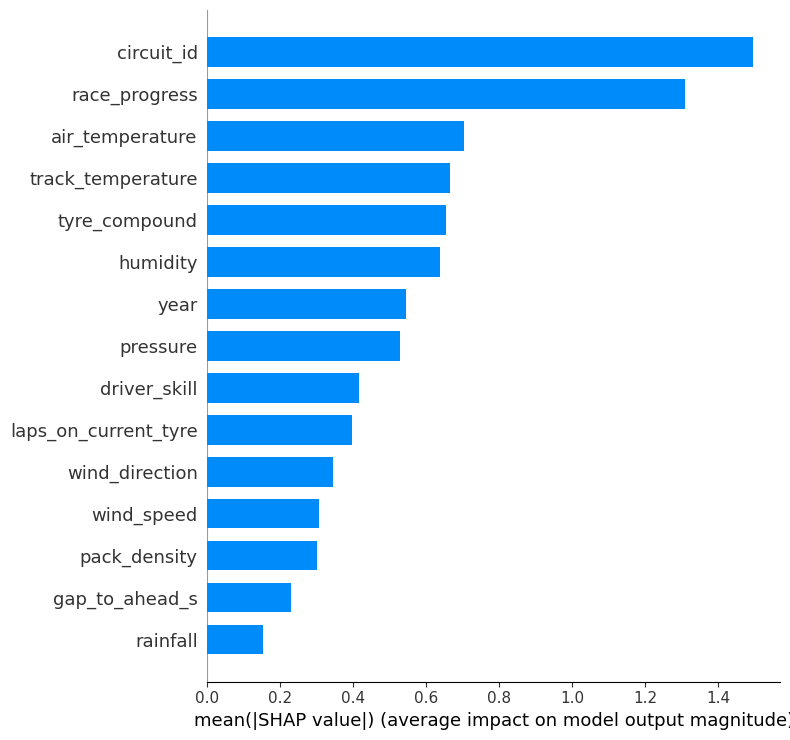

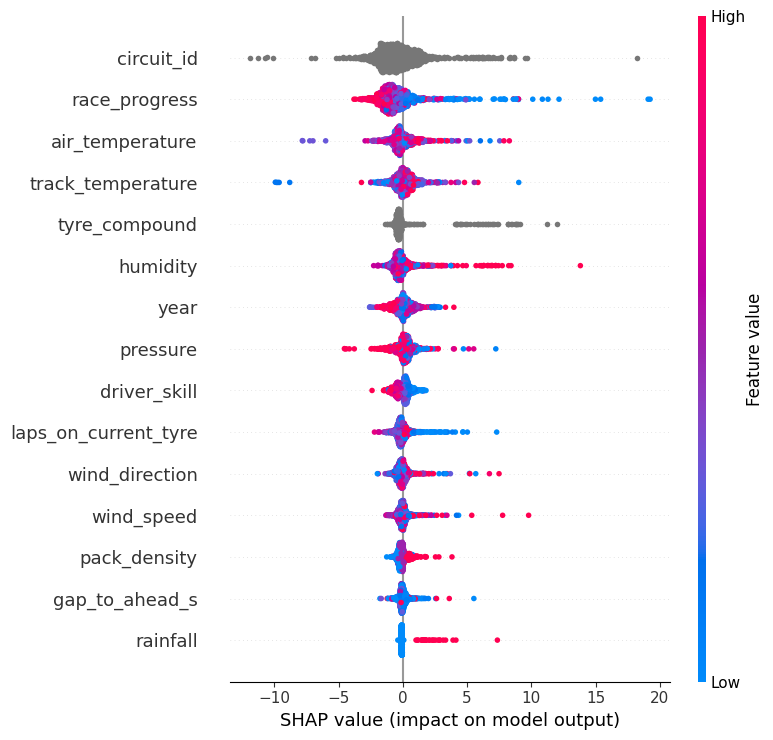

In [62]:
# 4. Predict on test set
preds = model.predict(X_test)
print("Sample predictions:", preds[:5])

# 5. Compute SHAP values
explainer = shap.TreeExplainer(model)

test_sample_size = min(1000, X_test.shape[0])
X_test_sample = X_test[:test_sample_size]

shap_values_test = explainer.shap_values(X_test_sample)

print(shap_values_test)

# 6. SHAP summary plot
shap.summary_plot(
    shap_values_test,
    X_test_sample,
    plot_type="bar"
)

shap.summary_plot(
    shap_values_test,
    X_test_sample,
)